In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt 
import seaborn
%matplotlib inline
seaborn.set()

In [202]:
import pandas as pd

# Questions

* How do we choose the anchor phase?

In the original implementation, this is obvious: take the phase of the first non-DC frequency bin.

Several options are available:

* Take the anchor phase from the first sample, or the center sample, etc
* Take some statistic (eg median) of the anchor phases across all samples

Ideally, we'd like a robust estimator that is not susceptible to noise in any single channel.

Possible solution?  `median(unwrap(anchors))`

In [733]:
def phase_anchor(data, aggregate=np.median, axis=-1):
    '''Multi-dimensional phase anchoring
    
    Given a mult-dimensional patch and an axis along which to apply an FFT,
    
    Parameters
    ----------
    data : np.ndarray, dtype=float
        The input data
        
    axis : int
        The axis along which to compute the FFT
        
    Returns
    -------
    data_aligned : np.ndarray like data
        data with each frame aligned to the first
    '''
    
    F = np.fft.rfft(data, axis=axis)
    
    mag = np.abs(F)
    phase = np.angle(F)
    
    
    # Select the reference phase value
    #anchor_idx = [0] * F.ndim
    anchor_idx = [slice(None)] * F.ndim
    anchor_idx[axis] = 1
    
    #angle = phase[tuple(anchor_idx)]
    plt.plot(np.unwrap(phase[anchor_idx]))
    
    angle = aggregate(np.unwrap(phase[anchor_idx]))
    
    # Compute phase shifts for each bin
    phase_idx = [slice(None)] * F.ndim
    phase_idx[axis] = slice(1, None)
    shift = angle * np.arange(1, F.shape[axis])
    
    # This indexing will reshape shift to be broadcast-compatible with phase
    shift_idx = [np.newaxis] * F.ndim
    shift_idx[axis] = slice(None)
    phase[phase_idx] = phase[phase_idx] - shift[shift_idx]
    
    # Combine the magnitudes with our new phase
    F2 = mag * np.exp(1.j * phase)
    
    data_out = np.fft.irfft(F2, axis=axis)
    
    return data_out

In [163]:
files = librosa.util.find_files('/home/bmcfee/data/beatles_iso/audio/', ext='flac')

In [577]:
files[141]

"/home/bmcfee/data/beatles_iso/audio/The Beatles/10CD2_-_The_Beatles/CD2_-_04_-_Everybody's_Got_Something_To_Hide_Except_Me_and_My_Monkey.flac"

In [579]:
k = 141

In [580]:
labfiles = librosa.util.find_files('/home/bmcfee/data/beatles_iso/seglab_tut/', ext='lab')

In [584]:
!cat "{labfiles[k]}"

0.0000000 0.3600000 silence
0.3600000 10.1123109 intro 
10.1123109 20.1408759 refrain 
20.1408759 41.9985417 verse
41.9985417 52.4039630 refrain
52.4039630 74.7012945 verse
74.7012945 100.2437775 bridge 
100.2437775 110.9841822 refrain 
110.9841822 128.3405088 verseH
128.3405088 184.3200000 outro

In [592]:
segments = pd.read_table(labfiles[k], header=None, sep='\s+')

In [593]:
segments

,0,1,2
0,0.000000,0.360000,silence
1,0.360000,10.112311,intro
2,10.112311,20.140876,refrain
3,20.140876,41.998542,verse
4,41.998542,52.403963,refrain
5,52.403963,74.701294,verse
6,74.701294,100.243778,bridge
7,100.243778,110.984182,refrain
8,110.984182,128.340509,verseH
9,128.340509,184.320000,outro


In [594]:
y, sr = librosa.load(files[k])

In [595]:
cqgram = librosa.cqt(y, sr=sr)

In [596]:
tempo, beats = librosa.beat.beat_track(y=y, sr=sr)

In [597]:
subseg = librosa.segment.subsegment(cqgram, beats)

In [598]:
segment_frames = librosa.time_to_frames(segments[0].values)

In [599]:
zip( librosa.util.match_events(segment_frames, subseg), segments[0], segments[1], segments[2])

[(0, 0.0, 0.35999999999999999, 'silence'),
 (5, 0.35999999999999999, 10.112310899999999, 'intro'),
 (83, 10.112310899999999, 20.140875899999998, 'refrain'),
 (164, 20.140875899999998, 41.998541700000004, 'verse'),
 (334, 41.998541700000004, 52.403962999999997, 'refrain'),
 (417, 52.403962999999997, 74.701294499999989, 'verse'),
 (591, 74.701294499999989, 100.24377750000001, 'bridge'),
 (793, 100.24377750000001, 110.98418219999999, 'refrain'),
 (875, 110.98418219999999, 128.34050880000001, 'verseH'),
 (1010, 128.34050880000001, 184.31999999999999, 'outro')]

In [600]:
cqb = librosa.feature.sync(cqgram, subseg, aggregate=np.median)

In [694]:
patch = cqb[:, 83:164]

In [706]:
print patch.shape

(84, 81)


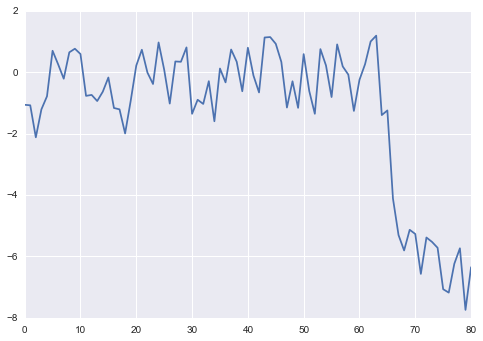

In [734]:
p2 = phase_anchor(patch, axis=0)

In [739]:
# Generate a synthetically pitch-shifted patch
patch_shift = np.roll(patch, -8, axis=0)
#patch_shift = cqb[:, 838:855]
#patch_shift = cqb[:, 334:334+164-83]

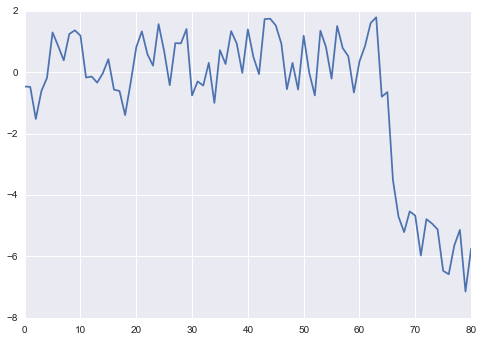

In [740]:
p3 = phase_anchor(patch_shift, axis=0)

In [741]:
patch.shape

(84, 81)

In [742]:
p2.shape

(84, 81)

In [743]:
p3.shape

(84, 81)

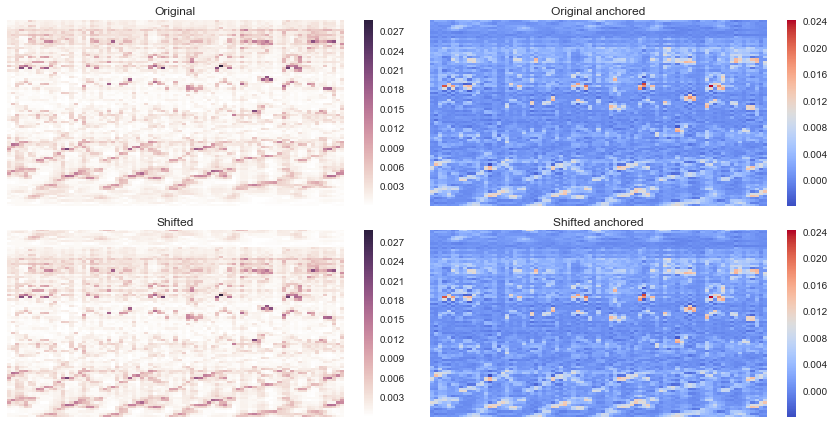

In [744]:
plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
librosa.display.specshow(patch)
plt.title('Original')
plt.colorbar()
plt.subplot(2,2,2)
librosa.display.specshow(p2)
plt.title('Original anchored')
plt.colorbar()
plt.subplot(2,2,3)
librosa.display.specshow(patch_shift)
plt.title('Shifted')
plt.colorbar()
plt.subplot(2,2,4)
librosa.display.specshow(p3)
plt.title('Shifted anchored')
plt.colorbar()
plt.tight_layout()

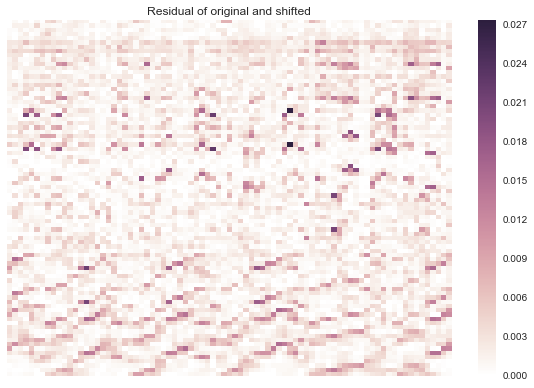

In [745]:
librosa.display.specshow(np.abs(patch - patch_shift))
plt.title('Residual of original and shifted')
plt.colorbar()
plt.tight_layout()

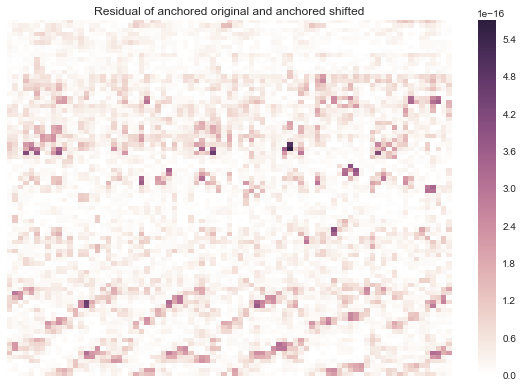

In [746]:
mpld3.disable_notebook()
librosa.display.specshow(np.abs(p2 - p3))
plt.title('Residual of anchored original and anchored shifted')
plt.colorbar()
plt.tight_layout()